In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv("data/feature_engineered/train_vars.csv", engine="python", on_bad_lines="skip")
print(df)

           text_id                                          full_text  \
0     0016926B079C  i think that students would benefit from learn...   
1     0022683E9EA5  when a problem is a change you have to let it ...   
2     00299B378633  dear, principal  if u change the school policy...   
3     003885A45F42  the best time in life is when you become yours...   
4     0049B1DF5CCC  small act of kindness can impact in other peop...   
...            ...                                                ...   
3926  FFD29828A873  i believe using cellphones in class for educat...   
3927  FFD9A83B0849  working alone, students do not have to argue w...   
3928  FFDC4011AC9C  "a problem is a chance for you to do your best...   
3929  FFE16D704B16  many people disagree with albert schweitzer's ...   
3930  FFED00D6E0BD  do you think that failure is the main thing fo...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  \
0          3.5     3.5         3.0          3.0   

In [54]:
label_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [55]:
feature_cols = df.columns.difference(['text_id', 'full_text'] + label_cols).tolist()

In [56]:
df = df.dropna()

In [57]:

class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        colwise_mse = self.mse(preds, targets).mean(dim=0)
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)
        return colwise_rmse.mean()

y_all = df[label_cols].values
X = df[feature_cols].values

# Split for all labels
X_train, X_test, y_train, y_test = train_test_split(X, y_all, test_size=0.2, random_state=42)

# model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# calculate Loss
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation RandomForestRegressor: {loss_value.item():.4f}")

Evaluation RandomForestRegressor: 0.5495


## Dimensionality reduction

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X)

In [48]:
y_all = df[label_cols].values
X = df[feature_cols].values

In [49]:
pca = PCA(n_components=30)  
X_pca = pca.fit_transform(X)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_all, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# calculate Loss
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation mit PCA: {loss_value.item():.4f}")

Evaluation mit PCA: 0.5598


### Using other models

GradientBoostingRegressor

In [51]:
from sklearn.ensemble import GradientBoostingRegressor


# Train one model per target
models = []
y_pred_list = []

for i in range(y_train.shape[1]):
    gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gbr.fit(X_train, y_train[:, i])
    y_pred = gbr.predict(X_test)
    y_pred_list.append(y_pred)
    models.append(gbr)

# Stack predictions to shape (n_samples, n_targets)
y_pred_stacked = np.stack(y_pred_list, axis=1)

# Convert to torch tensors for loss evaluation
y_pred_tensor = torch.tensor(y_pred_stacked, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Compute loss
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"MCRMSE with GradientBoosting: {loss_value.item():.4f}")

MCRMSE with GradientBoosting: 0.5508


HistGradientBoosting

In [38]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Wrap HistGradientBoostingRegressor for multi-target support
base_model = HistGradientBoostingRegressor(random_state=42)
model = MultiOutputRegressor(base_model)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Convert to torch tensors
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Calculate MCRMSE loss
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation mit HistGradientBoosting: {loss_value.item():.4f}")

Evaluation mit HistGradientBoosting: 0.5584


XGBRegressor

In [ ]:

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor


# XGB model wrapped for multi-output
xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
model = MultiOutputRegressor(xgb)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Convert to PyTorch tensors
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Calculate loss
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation mit XGBRegressor : {loss_value.item():.4f}")

Evaluation mit XGBRegressor : 0.5905


LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor


# Create and train LGBM model wrapped for multi-output
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Convert to PyTorch tensors
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Calculate loss
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation mit LGBMRegressor: {loss_value.item():.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 3123, number of used features: 30
[LightGBM] [Info] Start training from score 3.125040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 3123, number of used features: 30
[LightGBM] [Info] Start training from score 3.021774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 3123, number of used features: 30
[LightGBM] [Info] Start traini

/Users/sebastiankrause/Developer/feedback-prize/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sebastiankrause/Developer/feedback-prize/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sebastiankrause/Developer/feedback-prize/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sebastiankrause/Developer/feedback-prize/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sebastiankrause/Developer/feedback-prize/.venv/lib/python3.9/site-pac

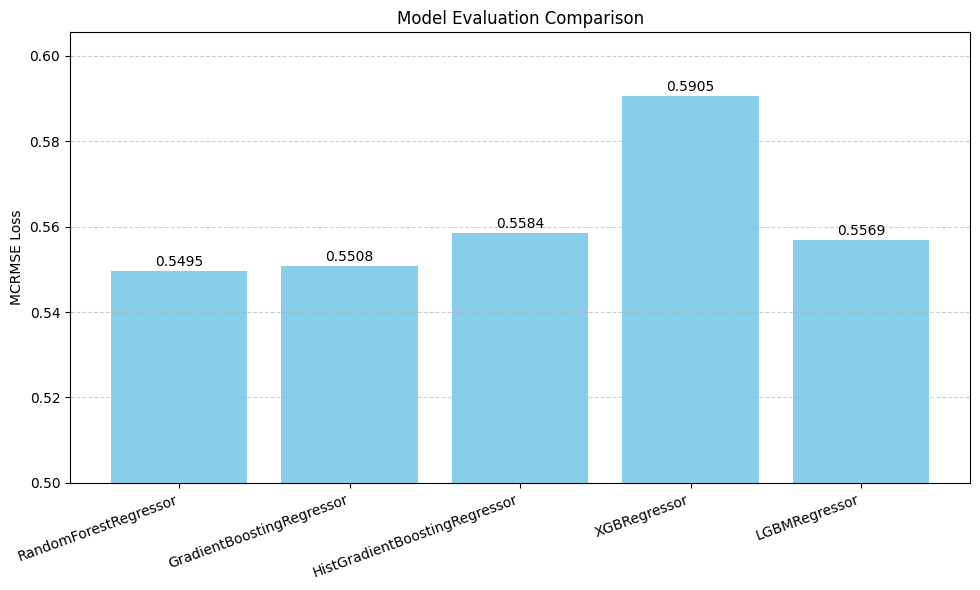

In [ ]:
results = {
    "RandomForestRegressor": 0.5495,
    "GradientBoostingRegressor": 0.5508,
    "HistGradientBoostingRegressor": 0.5584,
    "XGBRegressor": 0.5905,
    "LGBMRegressor": 0.5569
}

# In DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Regressor", "MCRMSE"])

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df["Regressor"], results_df["MCRMSE"], color='skyblue')

y_min = results_df["MCRMSE"].min() - 0.0495
y_max = results_df["MCRMSE"].max() + 0.015
plt.ylim(y_min, y_max)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.0005, f"{height:.4f}",
             ha='center', va='bottom', fontsize=10)

# Achsen und Titel
plt.ylabel("MCRMSE Loss")
plt.title("Model Evaluation Comparison")
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()